<a href="https://www.kaggle.com/code/mamun18/rsna-pneumonia-detection-with-pytorch-lightning?scriptVersionId=127893010" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## RSNA Pneumonia Detection Challenge

**Last updated: May 1, 2023 (completed)**

Competition Link: https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/

building an algorithm that automatically detects potential pneumonia cases using Pytorch Lightning

**About Challenge:** The competition challenges us to create an algorithm that can detect lung opacities on chest radiographs to aid in the accurate diagnosis of pneumonia, which is responsible for many deaths of children under 5 and emergency room visits in the US. Diagnosing pneumonia is difficult because other lung conditions and factors can cause increased opacity on the radiograph. CXRs are commonly used but their interpretation can be complicated and time-consuming, making an automated solution helpful in improving the efficiency and reach of diagnostic services. The Radiological Society of North America (RSNA®) has collaborated with Kaggle's machine learning community, the US National Institutes of Health, The Society of Thoracic Radiology, and MD.ai to create a dataset for this challenge.

**About Dataset:** This is an update to a two-stage machine learning challenge to develop an algorithm that detects pneumonia in medical images by automatically locating lung opacities on chest radiographs. The dataset contains training and test images in DICOM format, along with training labels that include bounding boxes for pneumonia and a binary target column indicating whether evidence of pneumonia is present. Competitors are expected to predict bounding boxes for areas of the lung where pneumonia is present. The file format for predictions should include confidence, x-min, y-min, width, and height values, and there should be only one predicted row per image.

The dataset for this challenge consists of chest radiographs in DICOM format. The training set contains a total of 26,684 images, which includes both the images from the stage 1 train set and the new stage 2 train set. The stage 2 test set contains 3,640 new, unseen images.




## Importing Necessary Libraries and reading files

In [1]:
from pathlib import Path
import pydicom
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# pytorch libraries for deep learning modelling
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
# reading labels data
labels = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [3]:
# defining the root path to importing images and files and save path to save the models and images
ROOT_PATH = Path("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("/kaggle/working/")

Now, we are going to generate a 3x3 grid of subplots, where each subplot displays a chest X-ray image from the training set along with its associated label. Where label 0 indicating no Pneumonia and 1 indicating there is some evidence of Pneuomia.

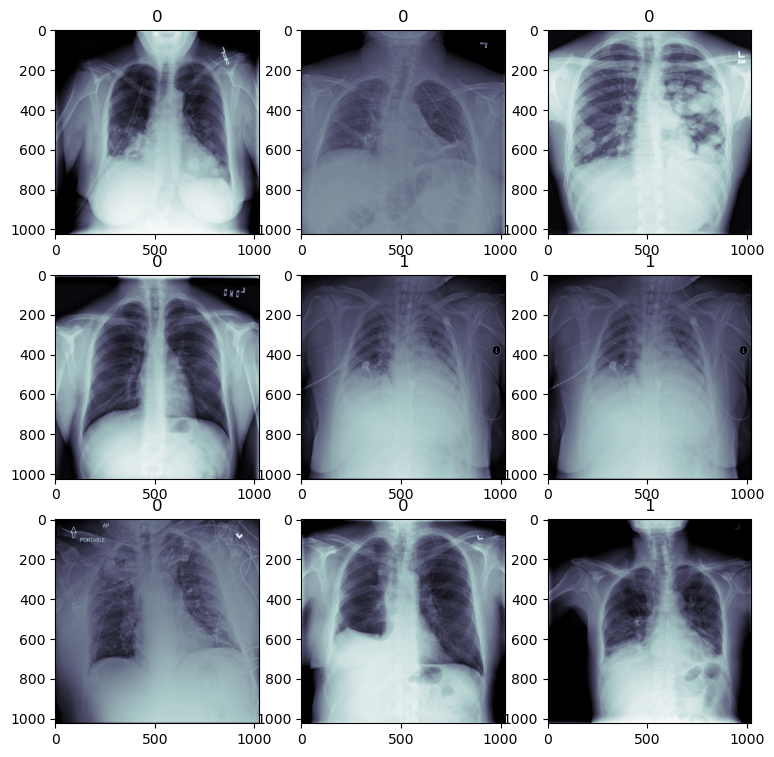

In [4]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        label = labels['Target'].iloc[c]
        
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c += 1

## Reading DICOM files and saved as .npy files

Following code reads in DICOM files for each patient in a given dataset, resizes them to 224x224, saves the pixel arrays as .npy files to be used for training or validation, and calculates the mean and variance of pixel values for the training set.

> The for loop iterates over the patient IDs in the "labels" DataFrame. For each patient, it reads in the DICOM file and converts the pixel array to a float between 0 and 1. It then resizes the pixel array to 224x224 using OpenCV's resize function, and saves the resized pixel array as a .npy file in a directory that corresponds to the patient's label ("0" or "1") and whether it's part of the training or validation set.

> If the patient is part of the training set (determined by the value of the counter variable "c"), it also calculates the sum of pixel values and the sum of squared pixel values to be used later for normalization. The normalizer is set to the total number of pixels in the image (224 * 224).

In [5]:
sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array / 255
        
        dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
        
        label = labels.Target.iloc[c]
        
        train_or_val = 'train' if c < 24000 else 'val'
        
        current_save_path = SAVE_PATH/train_or_val/str(label)
        current_save_path.mkdir(parents=True, exist_ok=True)
        np.save(current_save_path/patient_id, dcm_array)
        
        normalizer = 224 * 224
        if train_or_val == "train":
            sums += np.sum(dcm_array) / normalizer
            sums_squared += (dcm_array ** 2).sum() / normalizer

mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean ** 2)
mean, std

  0%|          | 0/30227 [00:00<?, ?it/s]

(0.4889087844122021, 0.24617960640014458)

In [6]:
# to load .npy file 
def load_file(path):
    return np.load(path).astype(np.float32)

## Defining Train and Validation Transforms

The follwing code defines two different sets of transformations to be applied to the images in the training and validation sets of a deep learning model.

> The purpose of these transformations is to increase the model's ability to generalize to new images and improve its overall performance.

> The train_transforms include various data augmentation techniques such as random affine transformations and random cropping to increase the variability of the training data and prevent overfitting.

> The val_transforms only includes normalization, which is necessary to ensure that the pixel values of the validation data are consistent with those of the training data. The same normalization parameters used for the training set are used for the validation set to ensure consistency.

In [7]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.5), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

## Defining training and validation dataset

I write the following code to create PyTorch datasets for training and validation using the DatasetFolder class from the torchvision.datasets module. Specifically, I define the directories where the preprocessed numpy arrays are saved for the training and validation sets, along with the loader to read the numpy files (load_file function), the file extension (.npy), and the data transforms (train_transforms for training and val_transforms for validation). This allows me to load and transform the data on the fly during training and validation using PyTorch dataloaders.

In [8]:
train_dataset = torchvision.datasets.DatasetFolder("/kaggle/working/train/", loader=load_file, extensions="npy", transform=train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("/kaggle/working/val/", loader=load_file, extensions="npy", transform=val_transforms)

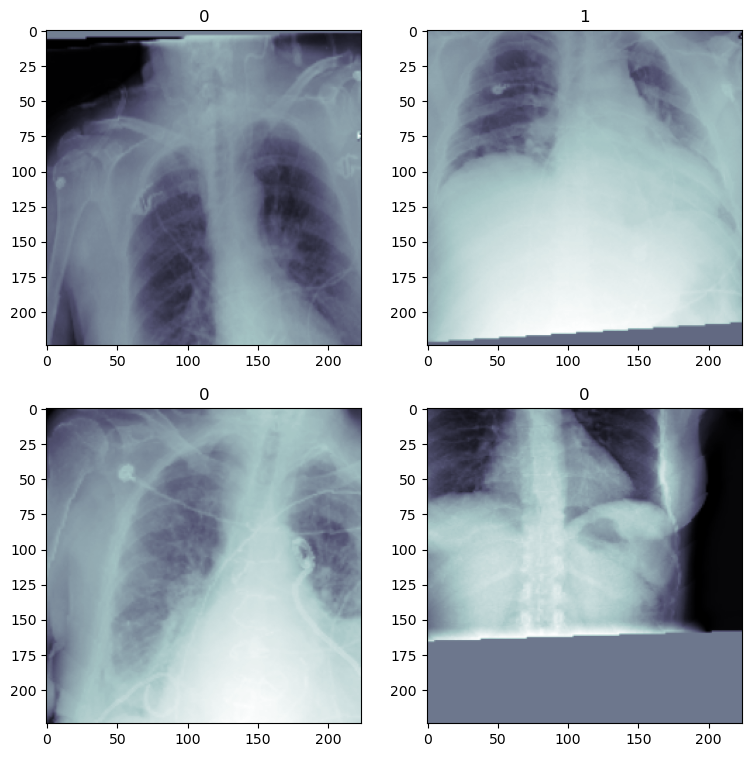

In [9]:
# Let's visualize 4 images from train dataset that are transformed 

fig, axis = plt.subplots(2, 2, figsize=(9, 9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, len(train_dataset))
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap='bone')
        axis[i][j].set_title(label)

## Defining hyperparams and creating dataloader

I created two data loaders (train_loader and val_loader) using PyTorch's DataLoader class to load the training and validation datasets respectively. The train_loader loads the data in batches of size 64 and shuffles the order of the samples in each epoch. The val_loader loads the validation data without shuffling. I used num_workers of 4 to parallelize the data loading process for faster performance.

In [10]:
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)


Let's see the unique labels and their corresponding frequency count in the train_dataset. If the dataset is balanced, we would expect to see a roughly equal count of each label. However, if the dataset is imbalanced, it means that some labels occur much more frequently than others. 

> In this case, the output of the code shows that there is a class imbalance in the train_dataset, meaning that the frequency of the labels is not equally distributed. The output provides information about the count of each unique label in the train_dataset. 

> If there is a large difference in the count of each label, it suggests that the dataset is imbalanced, which could lead to poor model performance in accurately predicting the underrepresented class.

In [11]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([16008,  4985]))

## Model Architecture

The following code defines a PyTorch Lightning module called `PneumoniaModel` for a binary classification task of detecting pneumonia from chest X-rays. The model architecture used is `ResNet18`, which is a popular convolutional neural network architecture. The model is modified by changing the number of input channels to 1 (since the input images are grayscale) and by changing the output layer to a single neuron for binary classification. The `BCEWithLogitsLoss` loss function is used, which combines binary cross entropy with logistic sigmoid function. The Adam optimizer is used with a learning rate of `1e-4`. The `train_acc` and `val_acc` metrics are initialized for computing the accuracy of the model during training and validation.

> The `forward` method defines the forward pass of the model, where the input data is passed through the `ResNet18` model and the predicted output is returned.

> The `training_step` method defines the training step for the model, where an input batch of X-ray images and their corresponding labels are passed to the model. The predicted output is computed using the model and the loss is computed using the BCEWithLogitsLoss loss function. The training accuracy and loss are logged using the train_acc and log methods, respectively. The method returns the loss.

> The `training_epoch_end` method logs the overall training accuracy of the model for the entire epoch.

> The `validation_step` method defines the validation step for the model, where an input batch of X-ray images and their corresponding labels are passed to the model. The predicted output is computed using the model and the loss is computed using the BCEWithLogitsLoss loss function. The validation accuracy and loss are logged using the val_acc and log methods, respectively.

> The `validation_epoch_end` method logs the overall validation accuracy of the model for the entire epoch.

> The `configure_optimizers` method returns the optimizer used for training, which is Adam with a learning rate of 1e-4.

In [12]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super(PneumoniaModel, self).__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')
        
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)
        
        self.log("Train loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    def training_epoch_end(self, outs):
        self.log("Train ACC", self.train_acc.compute())
        
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        self.log("Val loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))


    def validation_epoch_end(self, outs):
        self.log("Val ACC", self.val_acc.compute())
                 
    def configure_optimizers(self):
        return [self.optimizer]
               


In [13]:
model = PneumoniaModel()

A callback function called `ModelCheckpoint`, which is used to save the best performing model during training. The `monitor` parameter specifies the metric to monitor, which in this case is the validation accuracy (`Val ACC`). The `save_top_k` parameter specifies how many of the best models to save, with `10` indicating that the top 10 models will be saved. The `mode` parameter specifies whether to save the models with the highest or lowest value of the monitored metric, with `max` indicating that the models with the highest validation accuracy will be saved.

In [14]:
checkpoint_callback = ModelCheckpoint(
    monitor = 'Val ACC',
    save_top_k = 10,
    mode = 'max'
)

Let's initialize a PyTorch Lightning trainer object with the following configuration:

- `devices=1`: Specifies that the model should be trained on a single GPU.
- `logger=TensorBoardLogger(save_dir='./log')`: Specifies that logs should be written to a TensorBoard file in the `./log` directory.
- `log_every_n_steps=1`: Specifies that logs should be written every training step.
- `callbacks=checkpoint_callback`: Specifies that the `checkpoint_callback` object should be used to save model checkpoints.
- `max_epochs=10`: Specifies the maximum number of epochs to train the model for. 

Together, these settings indicate that the model will be trained on a single GPU, with logs written to a TensorBoard file and checkpoints saved at regular intervals. The training process will continue for a maximum of 10 epochs.

increase the epochs to get your desired accuracy

In [15]:
devices = 1
trainer = pl.Trainer(accelerator='gpu', devices=devices, logger=TensorBoardLogger(save_dir='./log'),
                    log_every_n_steps=1,
                    callbacks=checkpoint_callback, max_epochs=10)

In [16]:
trainer.fit(model, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

model.eval() will turned off the weight adjusting when we will inference

In [18]:
model.eval()
model.to(device)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

Creating empty lists for predictions and labels. Then, it is iterating over the validation dataset and for each data and label, it is sending the data to the device (e.g. GPU), converting to float, and adding an extra dimension with `unsqueeze(0)`. Then, it is passing the data through the model and applying sigmoid activation to the output. The prediction is added to the `preds` list and the label to the `labels` list.

Finally, the code is converting the `preds` and `labels` lists into PyTorch tensors.

In [19]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
        
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/5691 [00:00<?, ?it/s]


1. `torchmetrics.Accuracy(task='binary')` initializes an instance of the `Accuracy` class from the `torchmetrics` library, which is used for computing the accuracy score of binary classification problems. The `(preds, labels)` argument passed to this instance is used to compute the accuracy score.

2. `torchmetrics.Precision(task='binary')` initializes an instance of the `Precision` class from the `torchmetrics` library, which is used for computing the precision score of binary classification problems. The `(preds, labels)` argument passed to this instance is used to compute the precision score.

3. `torchmetrics.Recall(task='binary')` initializes an instance of the `Recall` class from the `torchmetrics` library, which is used for computing the recall score of binary classification problems. The `(preds, labels)` argument passed to this instance is used to compute the recall score.

4. `torchmetrics.ConfusionMatrix(task='binary', num_classes=2)` initializes an instance of the `ConfusionMatrix` class from the `torchmetrics` library, which is used for computing the confusion matrix of binary classification problems. The `(preds, labels)` argument passed to this instance is used to compute the confusion matrix.


In [20]:
acc = torchmetrics.Accuracy(task='binary')(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
cm = torchmetrics.ConfusionMatrix(task='binary', num_classes=2)(preds, labels)

print(f"Val Accuracy {acc}")
print(f"Val Precision {precision}")
print(f"Val Recall {recall}")
print(f"Confusion Matrix {cm}")

Val Accuracy 0.6740467548370361
Val Precision 0.34586745500564575
Val Recall 0.9045764207839966
Confusion Matrix tensor([[2907, 1757],
        [  98,  929]])
